# Applied Machine Learning: final project
## Multi-labeled text classification using Transformers (BERT) to predict image objects:
### - Author: Wei-Lun Tsai / wt2317@columbia.edu
### - Goal: predict image features given text features
> - Text features: title, tags, and descriptions
> - Image features: objects/words/sentences

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec 14 22:54:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    34W / 250W |   2091MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/AML/

/content/drive/MyDrive/AML


In [ ]:
%ls archive/USvideos.csv

archive/USvideos.csv


#### Target features:
- Thumbnail_link

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('archive/USvideos.csv')
df.head(5)

video_id  ...                                        description
0  2kyS6SvSYSE  ...  SHANTELL'S CHANNEL - https://www.youtube.com/s...
1  1ZAPwfrtAFY  ...  One year after the presidential election, John...
2  5qpjK5DgCt4  ...  WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3  puqaWrEC7tY  ...  Today we find out if Link is a Nickelback amat...
4  d380meD0W0M  ...  I know it's been a while since we did this sho...

[5 rows x 16 columns]

In [ ]:
df[['video_id', 'category_id', 'thumbnail_link']]

video_id  category_id                                  thumbnail_link
0      2kyS6SvSYSE           22  https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg
1      1ZAPwfrtAFY           24  https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg
2      5qpjK5DgCt4           23  https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg
3      puqaWrEC7tY           24  https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg
4      d380meD0W0M           24  https://i.ytimg.com/vi/d380meD0W0M/default.jpg
...            ...          ...                                             ...
40944  BZt0qjTWNhw           15  https://i.ytimg.com/vi/BZt0qjTWNhw/default.jpg
40945  1h7KV2sjUWY           22  https://i.ytimg.com/vi/1h7KV2sjUWY/default.jpg
40946  D6Oy4LfoqsU           24  https://i.ytimg.com/vi/D6Oy4LfoqsU/default.jpg
40947  oV0zkMe1K8s            1  https://i.ytimg.com/vi/oV0zkMe1K8s/default.jpg
40948  ooyjaVdt-jA           20  https://i.ytimg.com/vi/ooyjaVdt-jA/default.jpg

[40949 rows x 3 columns]

In [ ]:
import re
video_objs = dict()

# read the done parts
imgobj_file = 'image_objects.txt'
with open(imgobj_file) as f:
    lines = f.readlines()

for line in lines:
#     line = re.sub("\s", '', line)
    obj_list = line.split(',')
    video_objs[obj_list[0]] = obj_list[1:-1]

# ['NA']: image not avaliable
# []: no object detected
video_objs

{'5qpjK5DgCt4': ['NA'],
 'puqaWrEC7tY': ['person'],
 'd380meD0W0M': ['person', 'person', 'person'],
 'gHZ1Qz0KiKM': ['person', 'cell phone', 'remote'],
 '39idVpFF7NQ': ['person', 'tie', 'tie', 'person', 'bottle', 'clock'],
 'nc99ccSXST0': ['cake', 'cake', 'cake', 'cup', 'cup', 'person'],
 'jr9QtXwC9vc': ['person'],
 'TUmyygCMMGA': [],
 '9wRQljFNDW8': ['person', 'person', 'person', 'baseball glove'],
 'VifQlJit6A0': ['dog'],
 '5E4ZBSInqUU': ['NA'],
 'GgVmn66oK_A': ['person', 'person', 'person'],
 'TaTleo4cOs8': [],
 'kgaO45SyaO4': [],
 'ZAQs-ctOqXQ': ['person'],
 'YVfyYrEmzgM': [],
 'eNSN6qet1kE': ['dog', 'airplane', 'person'],
 'B5HORANmzHw': ['suitcase', 'train'],
 'vU14JY3x81A': [],
 '6VhU_T463sU': ['scissors', 'person'],
 '_-aDHxoblr4': ['person'],
 'JBZTZZAcFTw': ['person'],
 'lZ68j2J_GOM': ['person'],
 'dRpNZV18N_g': ['pizza'],
 'fcVjitaM3LY': ['person'],
 'qeWvgZLz9yU': ['person', 'person', 'cell phone'],
 'iIxy3JN3-jc': ['person',
  'person',
  'cell phone',
  'person',
  'chair

In [ ]:
!pip install imageai
!pip install ISR

In [ ]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import requests # to get image from the web
import shutil # to save it locally
from imageai.Detection import ObjectDetection
import warnings
warnings.filterwarnings('ignore')
from ISR.models import RDN

## Object detection:
# https://towardsdatascience.com/object-detection-with-10-lines-of-code-d6cb4d86f606
# https://imageai.readthedocs.io/en/latest/detection/

## Super resolution:
# https://pypi.org/project/ISR/

# model for super resolution
rdn = RDN(arch_params={'C':6, 'D':20, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C6-D20-G64-G064-x2_ArtefactCancelling_epoch219.hdf5')

#
for index, row in df.iterrows():

    vid = row['video_id']
    image_url = 'http://i3.ytimg.com/vi/' + vid + '/maxresdefault.jpg' #row['thumbnail_link']
    print(index, ':', vid, ':', image_url)
    
    if vid in video_objs:
        continue
    
    # write to file
    imgobj_fh = open(imgobj_file, "a")
    
#    # plot image
#     image = Image.open(requests.get(url, stream=True).raw)
#     plt.imshow(images)
#     plt.axis("off")
#     plt.show()

    ## Set up the image URL and filename
    images_path = "images/"
    filename = images_path + vid + ".jpg"
#     resfilename = images_path + vid + "_res.jpg" 
    newfilename = images_path + vid + "_new.jpg"
    image_vld = 0
    objects = []

    ## get image from url
    # Open the url image, set stream to True, this will return the stream content.
    if os.path.exists(filename):
        print('Image existed.')
        image_vld = 1
    else:
        r = requests.get(image_url, stream = True)

        # Check if the image was retrieved successfully
        if r.status_code == 200:
            # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
            r.raw.decode_content = True

            # Open a local file with wb ( write binary ) permission.
            with open(filename,'wb') as f:
                shutil.copyfileobj(r.raw, f)

            image_vld = 1
            print('Image sucessfully Downloaded.')
        else:
            image_vld = 0
            print('Image Couldn\'t be retreived.')
    
    
    imgobj_fh.write("%s," % vid)
    
    if image_vld == 1:
        
        ## super resolution
#         img = Image.open(filename)
#         lr_img = np.array(img)
#         sr_img = rdn.predict(lr_img)
#         im1 = Image.fromarray(sr_img)
#         im1 = im1.save(resfilename)
        
        ## object detection
        execution_path = os.getcwd()
        detector = ObjectDetection()
        detector.setModelTypeAsRetinaNet()
        detector.setModelPath(os.path.join(execution_path, "resnet50_coco_best_v2.1.0.h5"))
        detector.loadModel()
        detections = detector.detectObjectsFromImage(
#             input_image=os.path.join(execution_path, resfilename),
            input_image=os.path.join(execution_path, filename),
            output_image_path=os.path.join(execution_path, newfilename)
        )
        for eachObject in detections:
            obj_name = eachObject["name"]
            obj_prob = eachObject["percentage_probability"]
            print('---->', obj_name, ':', obj_prob)
            
            if obj_prob > 0.5:
                objects.append(obj_name)
                imgobj_fh.write("%s," % obj_name)
    else:
        obj_name = 'NA'
        imgobj_fh.write("%s," % obj_name)
        
    
    imgobj_fh.write('\n')
        
    video_objs[vid] = objects
#     print("video_objs: ", video_objs)
    
    # save file
    imgobj_fh.close()

In [ ]:
video_objs

{'5qpjK5DgCt4': ['NA'],
 'puqaWrEC7tY': ['person'],
 'd380meD0W0M': ['person', 'person', 'person'],
 'gHZ1Qz0KiKM': ['person', 'cell phone', 'remote'],
 '39idVpFF7NQ': ['person', 'tie', 'tie', 'person', 'bottle', 'clock'],
 'nc99ccSXST0': ['cake', 'cake', 'cake', 'cup', 'cup', 'person'],
 'jr9QtXwC9vc': ['person'],
 'TUmyygCMMGA': [],
 '9wRQljFNDW8': ['person', 'person', 'person', 'baseball glove'],
 'VifQlJit6A0': ['dog'],
 '5E4ZBSInqUU': ['NA'],
 'GgVmn66oK_A': ['person', 'person', 'person'],
 'TaTleo4cOs8': [],
 'kgaO45SyaO4': [],
 'ZAQs-ctOqXQ': ['person'],
 'YVfyYrEmzgM': [],
 'eNSN6qet1kE': ['dog', 'airplane', 'person'],
 'B5HORANmzHw': ['suitcase', 'train'],
 'vU14JY3x81A': [],
 '6VhU_T463sU': ['scissors', 'person'],
 '_-aDHxoblr4': ['person'],
 'JBZTZZAcFTw': ['person'],
 'lZ68j2J_GOM': ['person'],
 'dRpNZV18N_g': ['pizza'],
 'fcVjitaM3LY': ['person'],
 'qeWvgZLz9yU': ['person', 'person', 'cell phone'],
 'iIxy3JN3-jc': ['person',
  'person',
  'cell phone',
  'person',
  'chair

In [ ]:
# write video_obj to file to speed up next time

# analysis vide_objects
unique_objs = set()
for idx, key in enumerate(video_objs):
    objects = video_objs[key]
    obj_set = set(objects)
    unique_objs = unique_objs | obj_set
    
    for item in obj_set:
        count = objects.count(item)
#         print(key, item, count)
len(unique_objs), unique_objs

(80,
 {'NA',
  'airplane',
  'apple',
  'backpack',
  'banana',
  'baseball bat',
  'baseball glove',
  'bear',
  'bed',
  'bench',
  'bicycle',
  'bird',
  'boat',
  'book',
  'bottle',
  'bowl',
  'broccoli',
  'bus',
  'cake',
  'car',
  'carrot',
  'cat',
  'cell phone',
  'chair',
  'clock',
  'couch',
  'cow',
  'cup',
  'dining table',
  'dog',
  'donut',
  'elephant',
  'fire hydrant',
  'fork',
  'frisbee',
  'giraffe',
  'hair dryer',
  'handbag',
  'horse',
  'hot dog',
  'keyboard',
  'kite',
  'knife',
  'laptop',
  'microwave',
  'motorcycle',
  'mouse',
  'orange',
  'oven',
  'parking meter',
  'person',
  'pizza',
  'potted plant',
  'refrigerator',
  'remote',
  'sandwich',
  'scissors',
  'sheep',
  'sink',
  'skateboard',
  'skis',
  'snowboard',
  'spoon',
  'sports ball',
  'stop sign',
  'suitcase',
  'surfboard',
  'teddy bear',
  'tennis racket',
  'tie',
  'toilet',
  'toothbrush',
  'traffic light',
  'train',
  'truck',
  'tv',
  'umbrella',
  'vase',
  'win

In [ ]:
# write video_obj to file to speed up next time

# analysis vide_objects
unique_objs = set()
for idx, key in enumerate(video_objs):
    objects = video_objs[key]
    obj_set = set(objects)
    unique_objs = unique_objs | obj_set

unique_objs_list = list(unique_objs)
unique_objs_list.append('NA_OBJ')

#     for item in obj_set:
#         count = objects.count(item)
#         print(key, item, count)
# len(unique_objs), unique_objs

obj_count = dict()
for idx, vid in enumerate(video_objs):
    obj_count[vid] = []
    
    for unique_obj in unique_objs_list:
        count = 0
        for video_object in video_objs[vid]:
            if video_object == unique_obj:
                count += 1
#         obj_count[vid].append(count)
        obj_count[vid].append(count)
        
    if sum(obj_count[vid]) == 0: # image existed, but no object detected
        obj_count[vid][-1] = 1

In [ ]:
obj_df = pd.DataFrame(obj_count).transpose()

unique_objs_list
rename_list = {idx: val for idx, val in enumerate(unique_objs_list)}

obj_df = obj_df.rename(columns=rename_list)
obj_df

fork  parking meter  backpack  ...  scissors  tie  NA_OBJ
5qpjK5DgCt4     0              0         0  ...         0    0       0
puqaWrEC7tY     0              0         0  ...         0    0       0
d380meD0W0M     0              0         0  ...         0    0       0
gHZ1Qz0KiKM     0              0         0  ...         0    0       0
39idVpFF7NQ     0              0         0  ...         0    2       0
...           ...            ...       ...  ...       ...  ...     ...
6h8QgZF5Qu4     0              0         0  ...         0    0       0
mpnshdmtE2Y     0              0         0  ...         0    0       0
yz7Xq3T0YPs     0              0         0  ...         0    0       0
1ZAPwfrtAFY     0              0         0  ...         0    1       0
2kyS6SvSYSE     0              0         0  ...         0    0       0

[6351 rows x 81 columns]

In [ ]:
unique_objs_list
object_sum_df = pd.DataFrame(obj_df.sum())
object_sum_list = object_sum_df[0].to_list()

unique_objs_list_new = [x for _,x in sorted(zip(object_sum_list, unique_objs_list), reverse=True)]
object_sum_list.sort(reverse=True)

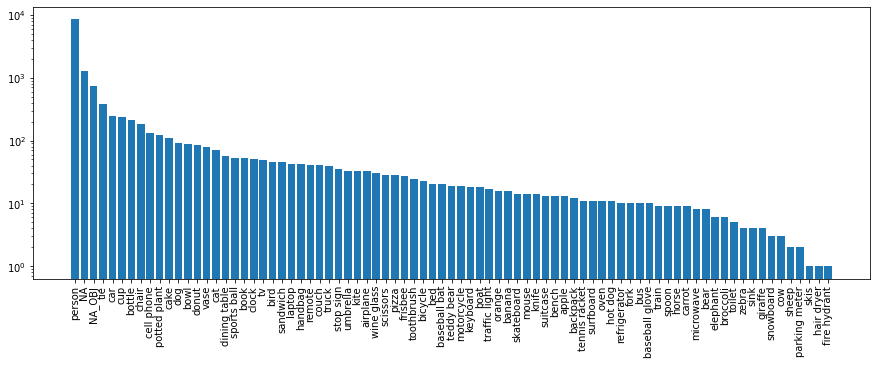

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15, 5))
plt.bar(unique_objs_list_new, object_sum_list)
plt.xticks(rotation='vertical')
plt.yscale('log')
plt.show()

In [ ]:
import re
video_ocr = dict()

# read the done parts
imgocr_file = 'image_ocr.txt'
with open(imgocr_file, encoding="utf-8") as f:
    lines = f.readlines()

for line in lines:
    line = re.sub("\s", '', line)
    obj_list = line.split(':')
    video_ocr[obj_list[0]] = obj_list[1]

video_ocr

{'5qpjK5DgCt4': '',
 'puqaWrEC7tY': '',
 'd380meD0W0M': '',
 'gHZ1Qz0KiKM': '',
 '39idVpFF7NQ': '',
 'nc99ccSXST0': '',
 'jr9QtXwC9vc': 'SHOWMAN72',
 'TUmyygCMMGA': 'EPISODE1',
 '9wRQljFNDW8': 'LEWIS’103-YARDRE’TURNTD!PATRIOTSVS.BRONCOS',
 'VifQlJit6A0': '',
 '5E4ZBSInqUU': '',
 'GgVmn66oK_A': 'FAILING—4COUNTRIESbee',
 'TaTleo4cOs8': '',
 'kgaO45SyaO4': '',
 'ZAQs-ctOqXQ': '',
 'YVfyYrEmzgM': "HOWDOESSYOURBODY<™KNOWYOU'REottFULbyffwiheedow(5ftepcha*",
 'eNSN6qet1kE': '',
 'B5HORANmzHw': '_|INBREEDING-FREESPAGE=.',
 'vU14JY3x81A': '',
 '6VhU_T463sU': '',
 '_-aDHxoblr4': 'BUILTFoRitrekSCIENCE_UN',
 'JBZTZZAcFTw': '',
 'lZ68j2J_GOM': '',
 'dRpNZV18N_g': 'HOWTOMAKEASPAGHETTI',
 'fcVjitaM3LY': '10223X2311721651Numberphile',
 'qeWvgZLz9yU': '',
 'iIxy3JN3-jc': '',
 'n30k5CwLhS4': '',
 'U0hAC8O7RoI': '',
 'CBVGjS_EJok': '',
 'n1WpP7iowLc': 'boke',
 'hz7ukDjuq4w': '',
 'p2hJxyF7mok': '',
 '0mlNzVSJrT0': '',
 'Om_zGhJLZ5U': '',
 'e_7zHm7GsYc': '',
 'dQvIbulWCM4': '',
 'zZ9FciUx6gs': 'ICKELBACKT

In [ ]:
# OCR
import re
import pytesseract

images_path = "images/"

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

def write_ocr(idx, vid, has_words):
    imgocr_fh = open(imgocr_file, "a", encoding="utf-8")
    video_ocr[vid] = has_words
    string = vid + ':' + str(has_words)
    string2 = string + "\n"
    imgocr_fh.write(string2)
    print(idx, ":", string)
    imgocr_fh.close()
    
print(len(video_objs))
print(type(video_objs))
      
for idx, vid in enumerate(video_objs):
    _list = video_objs[vid]
    
    if vid in video_ocr:
        continue
    
    if 'NA' in _list:
        write_ocr(idx, vid, '')
        continue
        
    img_name = images_path + vid + ".jpg"
    words = pytesseract.image_to_string(img_name)
    
    if re.match("^\s*$", words):
        write_ocr(idx, vid, '')
    else:
        write_ocr(idx, vid, re.sub("\n", ' ', words))    

In [ ]:
import re
video_ocrs = dict()

# read the done parts
imgobj_file = 'image_ocr.txt'
with open(imgobj_file, encoding="utf-8") as f:
    lines = f.readlines()

for line in lines:
    line = re.sub("\s", '', line)
    obj_list = line.split(':')
    key = obj_list[0]
    val = obj_list[1::]
    val_str = ''.join(obj_list[1::])
    if not re.match("\w+", val_str):
        video_ocrs[key] = 0
    else:
        video_ocrs[key] = 1

# ['NA']: image not avaliable
# []: no object detected
ocr_df = pd.DataFrame(data=video_ocrs.items(), columns=['vid','ocr']).set_index('vid')
ocr_df

ocr
vid             
5qpjK5DgCt4    0
puqaWrEC7tY    0
d380meD0W0M    0
gHZ1Qz0KiKM    0
39idVpFF7NQ    0
...          ...
6h8QgZF5Qu4    0
mpnshdmtE2Y    1
yz7Xq3T0YPs    0
1ZAPwfrtAFY    0
2kyS6SvSYSE    0

[6351 rows x 1 columns]

In [ ]:
obj_df

fork  parking meter  backpack  ...  scissors  tie  NA_OBJ
5qpjK5DgCt4     0              0         0  ...         0    0       0
puqaWrEC7tY     0              0         0  ...         0    0       0
d380meD0W0M     0              0         0  ...         0    0       0
gHZ1Qz0KiKM     0              0         0  ...         0    0       0
39idVpFF7NQ     0              0         0  ...         0    2       0
...           ...            ...       ...  ...       ...  ...     ...
6h8QgZF5Qu4     0              0         0  ...         0    0       0
mpnshdmtE2Y     0              0         0  ...         0    0       0
yz7Xq3T0YPs     0              0         0  ...         0    0       0
1ZAPwfrtAFY     0              0         0  ...         0    1       0
2kyS6SvSYSE     0              0         0  ...         0    0       0

[6351 rows x 81 columns]

In [ ]:
ocr_df

ocr
vid             
5qpjK5DgCt4    0
puqaWrEC7tY    0
d380meD0W0M    0
gHZ1Qz0KiKM    0
39idVpFF7NQ    0
...          ...
6h8QgZF5Qu4    0
mpnshdmtE2Y    1
yz7Xq3T0YPs    0
1ZAPwfrtAFY    0
2kyS6SvSYSE    0

[6351 rows x 1 columns]

In [ ]:
features = ['video_id', 'category_id']
df_features = df[features]
df_features = df_features.drop_duplicates(subset=['video_id']).set_index('video_id')
df_features

category_id
video_id                
2kyS6SvSYSE           22
1ZAPwfrtAFY           24
5qpjK5DgCt4           23
puqaWrEC7tY           24
d380meD0W0M           24
...                  ...
dS5Thrl-4Kc           26
JGm9Y_hFqNk           17
6h8QgZF5Qu4           24
mpnshdmtE2Y           26
yz7Xq3T0YPs           24

[6351 rows x 1 columns]

In [ ]:
# df1 = df.groupby('video_id')['category_id'].nunique()
# df1

In [ ]:
df_label = pd.concat([obj_df, ocr_df], axis=1)
df_label[df_label != 0] = 1
df_label

fork  parking meter  backpack  ...  tie  NA_OBJ  ocr
vid                                         ...                  
5qpjK5DgCt4     0              0         0  ...    0       0    0
puqaWrEC7tY     0              0         0  ...    0       0    0
d380meD0W0M     0              0         0  ...    0       0    0
gHZ1Qz0KiKM     0              0         0  ...    0       0    0
39idVpFF7NQ     0              0         0  ...    1       0    0
...           ...            ...       ...  ...  ...     ...  ...
6h8QgZF5Qu4     0              0         0  ...    0       0    0
mpnshdmtE2Y     0              0         0  ...    0       0    1
yz7Xq3T0YPs     0              0         0  ...    0       0    0
1ZAPwfrtAFY     0              0         0  ...    1       0    0
2kyS6SvSYSE     0              0         0  ...    0       0    0

[6351 rows x 82 columns]

In [ ]:
df_cv_vis = pd.concat([df_features, df_label], axis=1)
df_cv_vis

category_id  fork  parking meter  ...  tie  NA_OBJ  ocr
2kyS6SvSYSE           22     0              0  ...    0       0    0
1ZAPwfrtAFY           24     0              0  ...    1       0    0
5qpjK5DgCt4           23     0              0  ...    0       0    0
puqaWrEC7tY           24     0              0  ...    0       0    0
d380meD0W0M           24     0              0  ...    0       0    0
...                  ...   ...            ...  ...  ...     ...  ...
dS5Thrl-4Kc           26     0              0  ...    0       0    0
JGm9Y_hFqNk           17     0              0  ...    1       0    0
6h8QgZF5Qu4           24     0              0  ...    0       0    0
mpnshdmtE2Y           26     0              0  ...    0       0    1
yz7Xq3T0YPs           24     0              0  ...    0       0    0

[6351 rows x 83 columns]

In [ ]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)
df_cv_vis.apply(pd.value_counts)

category_id    fork  parking meter  ...     tie  NA_OBJ     ocr
0           NaN  6342.0         6349.0  ...  6038.0  5602.0  5093.0
1         318.0     9.0            2.0  ...   313.0   749.0  1258.0
2          70.0     NaN            NaN  ...     NaN     NaN     NaN
10        799.0     NaN            NaN  ...     NaN     NaN     NaN
15        138.0     NaN            NaN  ...     NaN     NaN     NaN
17        451.0     NaN            NaN  ...     NaN     NaN     NaN
19         60.0     NaN            NaN  ...     NaN     NaN     NaN
20        103.0     NaN            NaN  ...     NaN     NaN     NaN
22        498.0     NaN            NaN  ...     NaN     NaN     NaN
23        547.0     NaN            NaN  ...     NaN     NaN     NaN
24       1619.0     NaN            NaN  ...     NaN     NaN     NaN
25        505.0     NaN            NaN  ...     NaN     NaN     NaN
26        595.0     NaN            NaN  ...     NaN     NaN     NaN
27        250.0     NaN            NaN  ...     NaN     NaN     NaN
28        380.0     NaN            NaN  ...     NaN     NaN     NaN
29         14.0     NaN            NaN  ...     NaN     NaN     NaN
43          4.0     NaN            NaN  ...     NaN     NaN     NaN

[17 rows x 83 columns]

In [ ]:
# cols = ['category_id', 'chair', 'car', 'tie', 'potted plant', 'person', 'ocr']
# df_cv_new = df_cv[cols]
# df_cv_new

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline

# features = cols
# ncols = 2
# nrows = int(len(features) / ncols) + (len(features) % ncols != 0)

# fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7.5*ncols, 5*nrows))
# for idx, col in enumerate(features):
#     i, j = idx // ncols, idx % ncols
#     axs[i][j].scatter(df_cv_new['category_id'], df_cv_new[col], s=5, label='')
#     axs[i][j].set_xlabel('category_id')
#     axs[i][j].set_ylabel(col)

In [ ]:
# unique_objs_list

In [ ]:
# for col in unique_objs_list:
#     print()
df_cv_vis.groupby(['category_id']).apply(lambda column: (column != 0).sum())

category_id  fork  parking meter  ...  tie  NA_OBJ  ocr
category_id                                    ...                  
1                    318     0              0  ...   14      47   95
2                     70     0              0  ...    0       7    9
10                   799     1              0  ...   13     111  174
15                   138     0              0  ...    1      25   11
17                   451     0              0  ...   40      26   84
19                    60     1              0  ...    3      10   14
20                   103     0              0  ...    1      33   24
22                   498     1              0  ...   12      43   60
23                   547     1              1  ...   54      29  106
24                  1619     2              0  ...   88      74  313
25                   505     0              0  ...   72      69   87
26                   595     3              1  ...    6      48   89
27                   250     0              0  ...    5     125  106
28                   380     0              0  ...    2     102   83
29                    14     0              0  ...    2       0    3
43                     4     0              0  ...    0       0    0

[16 rows x 83 columns]

In [ ]:
df_label = pd.concat([obj_df, ocr_df], axis=1)
df_label[df_label != 0] = 1
df_label = df_cv_vis[['chair', 'car', 'tie', 'potted plant', 'person', 'ocr']]
df_label

chair  car  tie  potted plant  person  ocr
2kyS6SvSYSE      0    0    0             0       0    0
1ZAPwfrtAFY      0    0    1             0       1    0
5qpjK5DgCt4      0    0    0             0       0    0
puqaWrEC7tY      0    0    0             0       1    0
d380meD0W0M      0    0    0             0       1    0
...            ...  ...  ...           ...     ...  ...
dS5Thrl-4Kc      0    0    0             0       1    0
JGm9Y_hFqNk      0    0    1             0       1    0
6h8QgZF5Qu4      0    0    0             0       0    0
mpnshdmtE2Y      0    0    0             0       1    1
yz7Xq3T0YPs      0    0    0             0       1    0

[6351 rows x 6 columns]

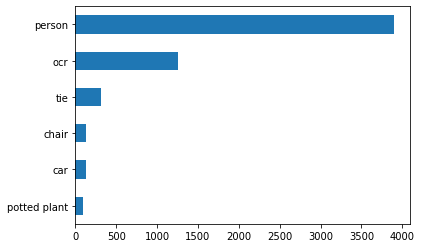

In [ ]:
LABEL_COLUMNS = df_label.columns.tolist()
df_label[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

## Multi-labeled text classification using Transformers (BERT):
### predict image features given text features
- text features: title, tags, and descriptions
- image features: objects

In [ ]:
import pandas as pd
import string
import numpy as np
import json

# from keras.preprocessing.sequence import pad_sequences
# from keras.layers import Embedding, LSTM, Dense, Dropout
# from keras.preprocessing.text import Tokenizer
# from keras.callbacks import EarlyStopping
# from keras.models import Sequential
# import keras.utils as ku

# import tensorflow as tf
# tf.random.set_seed(2)
# from numpy.random import seed
# seed(1)

df_no_duplicate = df.drop_duplicates(subset=['video_id']).set_index('video_id')
df_no_duplicate = df_no_duplicate[['title', 'category_id', 'tags', 'description']]
df_cv = pd.concat([df_no_duplicate, df_label], axis=1)
df_cv = df_cv.loc[:,~df_cv.columns.duplicated()] # remove duplicated 'category_id'
df_cv

title  ...  ocr
video_id                                                        ...     
2kyS6SvSYSE                 WE WANT TO TALK ABOUT OUR MARRIAGE  ...    0
1ZAPwfrtAFY  The Trump Presidency: Last Week Tonight with J...  ...    0
5qpjK5DgCt4  Racist Superman | Rudy Mancuso, King Bach & Le...  ...    0
puqaWrEC7tY                   Nickelback Lyrics: Real or Fake?  ...    0
d380meD0W0M                           I Dare You: GOING BALD!?  ...    0
...                                                        ...  ...  ...
dS5Thrl-4Kc                      CRAYOLA MAKEUP | HIT OR MISS?  ...    0
JGm9Y_hFqNk  First Take reacts: Kyrie Irving says contract ...  ...    0
6h8QgZF5Qu4  Drop the Mic w/ Ashton Kutcher & Sean Diddy Combs  ...    0
mpnshdmtE2Y  Carla Makes BA Smashburgers | From the Test Ki...  ...    1
yz7Xq3T0YPs  Katherine Langford on 13 Reasons Why, Australi...  ...    0

[6351 rows x 10 columns]

In [ ]:
df_cv['title']

video_id
2kyS6SvSYSE                   WE WANT TO TALK ABOUT OUR MARRIAGE
1ZAPwfrtAFY    The Trump Presidency: Last Week Tonight with J...
5qpjK5DgCt4    Racist Superman | Rudy Mancuso, King Bach & Le...
puqaWrEC7tY                     Nickelback Lyrics: Real or Fake?
d380meD0W0M                             I Dare You: GOING BALD!?
                                     ...                        
dS5Thrl-4Kc                        CRAYOLA MAKEUP | HIT OR MISS?
JGm9Y_hFqNk    First Take reacts: Kyrie Irving says contract ...
6h8QgZF5Qu4    Drop the Mic w/ Ashton Kutcher & Sean Diddy Combs
mpnshdmtE2Y    Carla Makes BA Smashburgers | From the Test Ki...
yz7Xq3T0YPs    Katherine Langford on 13 Reasons Why, Australi...
Name: title, Length: 6351, dtype: object

In [ ]:
df_cv['tags']

video_id
2kyS6SvSYSE                                      SHANtell martin
1ZAPwfrtAFY    last week tonight trump presidency|"last week ...
5qpjK5DgCt4    racist superman|"rudy"|"mancuso"|"king"|"bach"...
puqaWrEC7tY    rhett and link|"gmm"|"good mythical morning"|"...
d380meD0W0M    ryan|"higa"|"higatv"|"nigahiga"|"i dare you"|"...
                                     ...                        
dS5Thrl-4Kc    Laura88Lee|"crayola"|"crayon makeup"|"crayola ...
JGm9Y_hFqNk    espn|"espn live"|"boston celtics"|"kyrie irvin...
6h8QgZF5Qu4    The Late Late Show|"Late Late Show"|"James Cor...
mpnshdmtE2Y    bon appetit|"burgers"|"cheeseburgers"|"how to ...
yz7Xq3T0YPs    jimmy|"kimmel"|"live"|"late"|"night"|"talk"|"s...
Name: tags, Length: 6351, dtype: object

In [ ]:
df_cv['description']

video_id
2kyS6SvSYSE    SHANTELL'S CHANNEL - https://www.youtube.com/s...
1ZAPwfrtAFY    One year after the presidential election, John...
5qpjK5DgCt4    WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
puqaWrEC7tY    Today we find out if Link is a Nickelback amat...
d380meD0W0M    I know it's been a while since we did this sho...
                                     ...                        
dS5Thrl-4Kc    Hey Larlees, todays video is me testing Crayol...
JGm9Y_hFqNk    First Take's Stephen A. Smith and Max Kellerma...
6h8QgZF5Qu4    James Corden and Ashton Kutcher square off in ...
mpnshdmtE2Y    Ground chuck is a great all-purpose, buy-it-an...
yz7Xq3T0YPs    Katherine talks about learning accents, growin...
Name: description, Length: 6351, dtype: object

In [ ]:
#remove punctuations and convert text to lowercase

import re

def clean_text(text):
    if isinstance(text, float):
#         print(text)
        return ''
    
    text = re.sub(r'http\:', 'httpzzz', text)
    text = re.sub(r'https\:', 'httpszzz', text)
    text = re.sub(r'www\.', 'httpswww', text)
    text = re.sub(r'amz\.', 'httpamz', text)
    text = ''.join(e for e in text if e not in string.punctuation).lower()
    text = re.sub(r'\w*httpzzz\w*', 'http', text)
    text = re.sub(r'\w*httpszzz\w*', 'http', text)
    text = re.sub(r'\w*httpswww\w*', 'httpswww', text)
    text = re.sub(r'\w*httpamz\w*', 'httpamz', text)
    
    text = text.encode('utf8').decode('ascii', 'ignore')
    return text

def clean_tags(text):
    
    text = ''.join(e if e != '|' else ' ' for e in text)
    text = ''.join(e for e in text if e not in string.punctuation).lower()
    
    text = text.encode('utf8').decode('ascii', 'ignore')
    return text

corpus_title = [clean_text(e) for e in df_cv['title']]
corpus_tags = [clean_tags(e) for e in df_cv['tags']]
corpus_description = [clean_text(e) for e in df_cv['description']]

In [ ]:
len(corpus_tags), corpus_tags

(6351,
 ['shantell martin',
  'last week tonight trump presidency last week tonight donald trump john oliver trump donald trump',
  'racist superman rudy mancuso king bach racist superman love rudy mancuso poo bear black white official music video iphone x by pineapple lelepons hannahstocking rudymancuso inanna anwar sarkis shots shotsstudios alesso anitta brazil getting my drivers license   lele pons',
  'rhett and link gmm good mythical morning rhett and link good mythical morning good mythical morning rhett and link mythical morning season 12 nickelback lyrics nickelback lyrics real or fake nickelback nickelback songs nickelback song rhett link nickelback gmm nickelback lyrics website category nickelback musical group rock music lyrics chad kroeger canada music industry mythical gmm challenge comedy funny challenge',
  'ryan higa higatv nigahiga i dare you idy rhpc dares no truth comments comedy funny stupid fail',
  'ijustine week with iphone x iphone x apple iphone iphone x review

In [ ]:
len(corpus_description), corpus_description

(6351,
 ['shantells channel  http  http this video in 4k on this  http this lens  http drone  http gear   http camera http camera http lens http sony camera http canon camera http tripod thing http need this for the bendy tripod http lens http expensive wide lens http camera http http microphone http drone cheaper but still http me on http http http intro song by http disclosure  this is not an ad  not selling or promoting anything  but samsung did produce the shantell video as a galaxy project which is an initiative that enables creators like shantell and me to make projects we might otherwise not have the opportunity to make  hope thats clear  if not ask in the comments and ill answer any specifics',
  'one year after the presidential election john oliver discusses what weve learned so far and enlists our catheter cowboy to teach donald trump what he hasntnnconnect with last week tonight onlinennsubscribe to the last week tonight youtube channel for more almost news as it almost happ

In [ ]:
len(corpus_title), corpus_title

(6351,
 ['we want to talk about our marriage',
  'the trump presidency last week tonight with john oliver hbo',
  'racist superman  rudy mancuso king bach  lele pons',
  'nickelback lyrics real or fake',
  'i dare you going bald',
  '2 weeks with iphone x',
  'roy moore  jeff sessions cold open  snl',
  '5 ice cream gadgets put to the test',
  'the greatest showman  official trailer 2 hd  20th century fox',
  'why the rise of the robots wont mean the end of work',
  'dion lewis 103yd kick return td vs denver  cantmiss play  nfl wk 10 highlights',
  'spoilers shiva saves the day talked about scene ep 804  the walking dead',
  'marshmello  blocks official music video',
  'which countries are about to collapse',
  'shopping for new fish',
  'the new spotmini',
  'one change that would make pacific rim a classic',
  'how does your body know youre full  hilary coller',
  'homemade electric airplane',
  'founding an inbreedingfree space colony',
  'how can you control your dreams',
  'the ma

In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('word_tokenize')
nltk.download('WordNetLemmatizer')
nltk.download('punkt') 

    
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def text_preprocessing(corpus):
    new_corpus = []
    stop_words = set(stopwords.words('english'))

    for sentence in corpus: # sentence = texts of a video
        word_tokens = word_tokenize(sentence)
        filtered_sentence = [lemmatizer.lemmatize(w) for w in word_tokens if not w.lower() in stop_words]
    #     print(word_tokens)
    #     print(filtered_sentence)
        new_corpus.append(filtered_sentence)
    
    return new_corpus
    
new_corpus_title = text_preprocessing(corpus_title)
new_corpus_tags = text_preprocessing(corpus_tags)
new_corpus_description = text_preprocessing(corpus_description)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading word_tokenize: Package 'word_tokenize' not
[nltk_data]     found in index
[nltk_data] Error loading WordNetLemmatizer: Package
[nltk_data]     'WordNetLemmatizer' not found in index
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
new_corpus_title, len(new_corpus_title)

([['want', 'talk', 'marriage'],
  ['trump', 'presidency', 'last', 'week', 'tonight', 'john', 'oliver', 'hbo'],
  ['racist', 'superman', 'rudy', 'mancuso', 'king', 'bach', 'lele', 'pons'],
  ['nickelback', 'lyric', 'real', 'fake'],
  ['dare', 'going', 'bald'],
  ['2', 'week', 'iphone', 'x'],
  ['roy', 'moore', 'jeff', 'session', 'cold', 'open', 'snl'],
  ['5', 'ice', 'cream', 'gadget', 'put', 'test'],
  ['greatest',
   'showman',
   'official',
   'trailer',
   '2',
   'hd',
   '20th',
   'century',
   'fox'],
  ['rise', 'robot', 'wont', 'mean', 'end', 'work'],
  ['dion',
   'lewis',
   '103yd',
   'kick',
   'return',
   'td',
   'v',
   'denver',
   'cantmiss',
   'play',
   'nfl',
   'wk',
   '10',
   'highlight'],
  ['spoiler',
   'shiva',
   'save',
   'day',
   'talked',
   'scene',
   'ep',
   '804',
   'walking',
   'dead'],
  ['marshmello', 'block', 'official', 'music', 'video'],
  ['country', 'collapse'],
  ['shopping', 'new', 'fish'],
  ['new', 'spotmini'],
  ['one', 'change'

In [ ]:
new_corpus_tags, len(new_corpus_tags)

([['shantell', 'martin'],
  ['last',
   'week',
   'tonight',
   'trump',
   'presidency',
   'last',
   'week',
   'tonight',
   'donald',
   'trump',
   'john',
   'oliver',
   'trump',
   'donald',
   'trump'],
  ['racist',
   'superman',
   'rudy',
   'mancuso',
   'king',
   'bach',
   'racist',
   'superman',
   'love',
   'rudy',
   'mancuso',
   'poo',
   'bear',
   'black',
   'white',
   'official',
   'music',
   'video',
   'iphone',
   'x',
   'pineapple',
   'lelepons',
   'hannahstocking',
   'rudymancuso',
   'inanna',
   'anwar',
   'sarkis',
   'shot',
   'shotsstudios',
   'alesso',
   'anitta',
   'brazil',
   'getting',
   'driver',
   'license',
   'lele',
   'pons'],
  ['rhett',
   'link',
   'gmm',
   'good',
   'mythical',
   'morning',
   'rhett',
   'link',
   'good',
   'mythical',
   'morning',
   'good',
   'mythical',
   'morning',
   'rhett',
   'link',
   'mythical',
   'morning',
   'season',
   '12',
   'nickelback',
   'lyric',
   'nickelback',
   'l

In [ ]:
new_corpus_description, len(new_corpus_description)

([['shantells',
   'channel',
   'http',
   'http',
   'video',
   '4k',
   'http',
   'lens',
   'http',
   'drone',
   'http',
   'gear',
   'http',
   'camera',
   'http',
   'camera',
   'http',
   'lens',
   'http',
   'sony',
   'camera',
   'http',
   'canon',
   'camera',
   'http',
   'tripod',
   'thing',
   'http',
   'need',
   'bendy',
   'tripod',
   'http',
   'lens',
   'http',
   'expensive',
   'wide',
   'lens',
   'http',
   'camera',
   'http',
   'http',
   'microphone',
   'http',
   'drone',
   'cheaper',
   'still',
   'http',
   'http',
   'http',
   'http',
   'intro',
   'song',
   'http',
   'disclosure',
   'ad',
   'selling',
   'promoting',
   'anything',
   'samsung',
   'produce',
   'shantell',
   'video',
   'galaxy',
   'project',
   'initiative',
   'enables',
   'creator',
   'like',
   'shantell',
   'make',
   'project',
   'might',
   'otherwise',
   'opportunity',
   'make',
   'hope',
   'thats',
   'clear',
   'ask',
   'comment',
   'ill',


In [ ]:
corpus = []
for i in range(len(new_corpus_title)):
    corpus.append(' <START> ' + ' '.join(e for e in new_corpus_title[i]) + ' <S1> ' + ' '.join(e for e in new_corpus_tags[i]) + ' <S2> ' + ' '.join(e for e in new_corpus_description[i]) + ' <END> ')
len(corpus), len(corpus[2]), corpus

(6351,
 658,
 [' <START> want talk marriage <S1> shantell martin <S2> shantells channel http http video 4k http lens http drone http gear http camera http camera http lens http sony camera http canon camera http tripod thing http need bendy tripod http lens http expensive wide lens http camera http http microphone http drone cheaper still http http http http intro song http disclosure ad selling promoting anything samsung produce shantell video galaxy project initiative enables creator like shantell make project might otherwise opportunity make hope thats clear ask comment ill answer specific <END> ',
  ' <START> trump presidency last week tonight john oliver hbo <S1> last week tonight trump presidency last week tonight donald trump john oliver trump donald trump <S2> one year presidential election john oliver discus weve learned far enlists catheter cowboy teach donald trump hasntnnconnect last week tonight onlinennsubscribe last week tonight youtube channel almost news almost happens

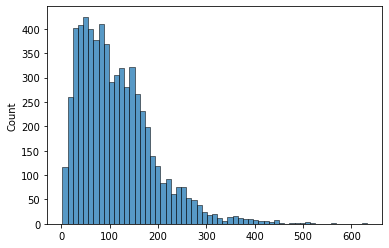

In [ ]:
# number of tokens

token_counts = []
for i in range(len(new_corpus_title)):
    token_counts.append(len(new_corpus_title[i]) + len(new_corpus_tags[i]) + len(new_corpus_description[i]))
#     print(len(new_corpus_title[i]), len(new_corpus_tags[i]), len(new_corpus_description[i]))

sns.histplot(token_counts)

In [ ]:
df_processsed = pd.DataFrame(corpus, columns=['comment_text'])
df_processsed['list'] = df_label.values.tolist()
df_processsed

comment_text                list
0      <START> want talk marriage <S1> shantell mart...  [0, 0, 0, 0, 0, 0]
1      <START> trump presidency last week tonight jo...  [0, 0, 1, 0, 1, 0]
2      <START> racist superman rudy mancuso king bac...  [0, 0, 0, 0, 0, 0]
3      <START> nickelback lyric real fake <S1> rhett...  [0, 0, 0, 0, 1, 0]
4      <START> dare going bald <S1> ryan higa higatv...  [0, 0, 0, 0, 1, 0]
...                                                 ...                 ...
6346   <START> crayola makeup hit miss <S1> laura88l...  [0, 0, 0, 0, 1, 0]
6347   <START> first take reacts kyrie irving say co...  [0, 0, 1, 0, 1, 0]
6348   <START> drop mic w ashton kutcher sean diddy ...  [0, 0, 0, 0, 0, 0]
6349   <START> carla make ba smashburgers test kitch...  [0, 0, 0, 0, 1, 1]
6350   <START> katherine langford 13 reason australi...  [0, 0, 0, 0, 1, 0]

[6351 rows x 2 columns]

In [ ]:
# !pip install keras

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

In [ ]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 450
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.comment_text
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset=df_processsed.sample(frac=train_size,random_state=200)
test_dataset=df_processsed.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df_processsed.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (6351, 2)
TRAIN Dataset: (5081, 2)
TEST Dataset: (1270, 2)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 6)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
def train(epoch):
    model.train()
    for i, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if (i+1) % 100 == 0:
            print(f'Epoch: {epoch}, step: {i}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

In [ ]:
model_name = 'model_epoch_' + str(EPOCHS) + '_batch_' + str(TRAIN_BATCH_SIZE) + '_lr_' + str(LEARNING_RATE) + '_maxlen_' + str(MAX_LEN)

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/AML/" + model_name)

In [ ]:
# model_name = 'model_epoch_10_batch_' + str(TRAIN_BATCH_SIZE) + '_lr_' + str(LEARNING_RATE) + '_maxlen_' + str(MAX_LEN)
# model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [ ]:
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
for epoch in range(1):

  outputs, targets = validation(epoch)

  outputs = np.array(outputs)
  keep_mask = outputs==0.5
  outputs = np.where(outputs>0.5, 1.0, 0.0)
  outputs[keep_mask] = 0.5
  
  total, glob_correct = 0, 0

  for i in range(len(targets)):
    target = targets[i]
    output = outputs[i]
    correct = 0
    for e in range(len(target)):
      total += 1
      if target[e] == output[e]: correct += 1
    # print(target, output, '===>', correct, glob_correct, total)
    glob_correct += correct

  print(f"Test accuracy = {100 * glob_correct/total} %")

Test accuracy = 87.92650918635171 %
